# 1️⃣ Setup + load data

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    mean_squared_error,
    r2_score
)

from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, SVR

import matplotlib.pyplot as plt
import seaborn as sns

DATA_PATH = "../data/institute_level_processed_most_recent.csv"

df = pd.read_csv(DATA_PATH)
print("Data shape:", df.shape)
print("Columns:", df.columns.tolist())



Data shape: (5650, 33)
Columns: ['UNITID', 'INSTNM', 'CITY', 'STABBR', 'LATITUDE', 'LONGITUDE', 'PCIP14', 'PCIP15', 'ENG_TOTAL', 'ENG_RATIO', 'PCIP11', 'STEM_TOTAL', 'STEM_RATIO', 'ENG_HEAVY', 'STEM_HEAVY', 'UGDS', 'UGDS_MEN', 'UGDS_WOMEN', 'DIVERSITY_SCORE', 'TUITIONFEE_IN', 'TUITIONFEE_OUT', 'COSTT4_A', 'TUITION_GAP', 'AFFORDABILITY_INDEX', 'MD_EARN_WNE_P10', 'RET_FT4', 'GRAD_RATE', 'ADM_RATE', 'QUALITY_SCORE', 'CONTROL', 'IS_PUBLIC', 'IS_PRIVATE', 'IS_FORPROFIT']


# 2️⃣ Define a non-trivial “value” label

Here I’ll define a VALUE_LABEL:

1 = high quality AND affordable

0 = otherwise

…and I purposely do NOT use COSTT4_A or QUALITY_SCORE as features, to avoid the trivial 1.0 metrics you saw before.

In [2]:
df = df.copy()

# Basic checks
for col in ["COSTT4_A", "QUALITY_SCORE"]:
    if col not in df.columns:
        raise ValueError(f"Column {col} is missing. Check your preprocessing.")

# Build a value label:
cost_med = df["COSTT4_A"].median()
quality_med = df["QUALITY_SCORE"].median()

df["VALUE_LABEL"] = (
    (df["COSTT4_A"] <= cost_med) &
    (df["QUALITY_SCORE"] >= quality_med)
).astype(int)

print("VALUE_LABEL distribution:")
print(df["VALUE_LABEL"].value_counts(dropna=False))


VALUE_LABEL distribution:
VALUE_LABEL
0    3902
1    1748
Name: count, dtype: int64


# Choose feature columns (no direct label leakage)

We’ll exclude: COSTT4_A, QUALITY_SCORE, AFFORDABILITY_INDEX from X.

In [3]:
feature_cols = [
    "ENG_RATIO", "STEM_RATIO",
    "ENG_HEAVY", "STEM_HEAVY",
    "UGDS", "UGDS_MEN", "UGDS_WOMEN",
    "DIVERSITY_SCORE",
    "TUITIONFEE_IN", "TUITIONFEE_OUT", "TUITION_GAP",
    "RET_FT4", "GRAD_RATE", "ADM_RATE",
    "MD_EARN_WNE_P10",
    "CONTROL", "IS_PUBLIC", "IS_PRIVATE", "IS_FORPROFIT"
]

# Keep only available columns
feature_cols = [c for c in feature_cols if c in df.columns]
print("Using features:", feature_cols)

# Drop rows missing target or all features
df_model = df.dropna(subset=["VALUE_LABEL"])
X = df_model[feature_cols]
y = df_model["VALUE_LABEL"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])


Using features: ['ENG_RATIO', 'STEM_RATIO', 'ENG_HEAVY', 'STEM_HEAVY', 'UGDS', 'UGDS_MEN', 'UGDS_WOMEN', 'DIVERSITY_SCORE', 'TUITIONFEE_IN', 'TUITIONFEE_OUT', 'TUITION_GAP', 'RET_FT4', 'GRAD_RATE', 'ADM_RATE', 'MD_EARN_WNE_P10', 'CONTROL', 'IS_PUBLIC', 'IS_PRIVATE', 'IS_FORPROFIT']
Train size: 4520
Test size: 1130


# 3️⃣ Multi-model CLASSIFICATION with GridSearchCV

We’ll try:

Logistic Regression

Random Forest

Gradient Boosting

KNN

All with GridSearchCV, optimizing ROC AUC.

In [4]:
classifiers = {}

# 1. Logistic Regression
log_reg_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000))
])

log_reg_param_grid = {
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__class_weight": [None, "balanced"]
}

classifiers["LogisticRegression"] = (log_reg_pipe, log_reg_param_grid)

# 2. Random Forest
rf_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", RandomForestClassifier(random_state=42))
])

rf_param_grid = {
    "clf__n_estimators": [200, 400],
    "clf__max_depth": [None, 5, 10, 20],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__class_weight": [None, "balanced"]
}

classifiers["RandomForest"] = (rf_pipe, rf_param_grid)

# 3. Gradient Boosting
gb_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", GradientBoostingClassifier(random_state=42))
])

gb_param_grid = {
    "clf__n_estimators": [100, 200],
    "clf__learning_rate": [0.01, 0.1],
    "clf__max_depth": [3, 5]
}

classifiers["GradientBoosting"] = (gb_pipe, gb_param_grid)

# 4. KNN
knn_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", KNeighborsClassifier())
])

knn_param_grid = {
    "clf__n_neighbors": [5, 15, 25],
    "clf__weights": ["uniform", "distance"]
}

classifiers["KNN"] = (knn_pipe, knn_param_grid)

# 5. Support Vector Classifier (with probability for ROC AUC)
svc_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", SVC(probability=True, random_state=42))
])

svc_param_grid = {
    "clf__C": [0.1, 1, 10],
    "clf__gamma": ["scale", "auto"],
    "clf__kernel": ["rbf", "linear"],
    "clf__class_weight": [None, "balanced"]
}

classifiers["SVC"] = (svc_pipe, svc_param_grid)



# Run all classifiers + print reports

Running LogisticRegression
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best params for LogisticRegression:
{'clf__C': 10, 'clf__class_weight': 'balanced'}
Best CV ROC AUC: 0.885

Test classification report:
              precision    recall  f1-score   support

           0       0.94      0.79      0.86       780
           1       0.65      0.89      0.75       350

    accuracy                           0.82      1130
   macro avg       0.80      0.84      0.81      1130
weighted avg       0.85      0.82      0.83      1130

Test ROC AUC: 0.8765567765567767
Confusion matrix:
[[615 165]
 [ 39 311]]


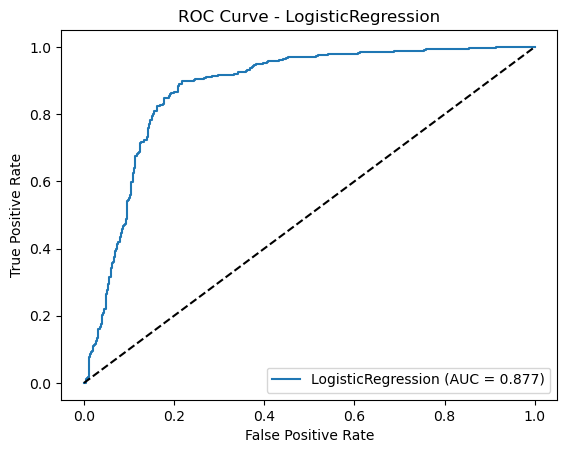

Running RandomForest
Fitting 5 folds for each of 144 candidates, totalling 720 fits

Best params for RandomForest:
{'clf__class_weight': 'balanced', 'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10, 'clf__n_estimators': 400}
Best CV ROC AUC: 0.993

Test classification report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       780
           1       0.91      0.91      0.91       350

    accuracy                           0.95      1130
   macro avg       0.94      0.94      0.94      1130
weighted avg       0.95      0.95      0.95      1130

Test ROC AUC: 0.9914505494505494
Confusion matrix:
[[750  30]
 [ 32 318]]


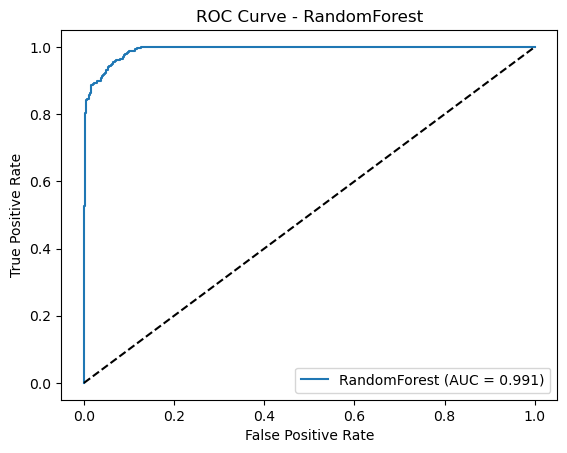

Running GradientBoosting
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best params for GradientBoosting:
{'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 200}
Best CV ROC AUC: 0.993

Test classification report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       780
           1       0.93      0.92      0.92       350

    accuracy                           0.95      1130
   macro avg       0.95      0.94      0.94      1130
weighted avg       0.95      0.95      0.95      1130

Test ROC AUC: 0.9918608058608058
Confusion matrix:
[[755  25]
 [ 29 321]]


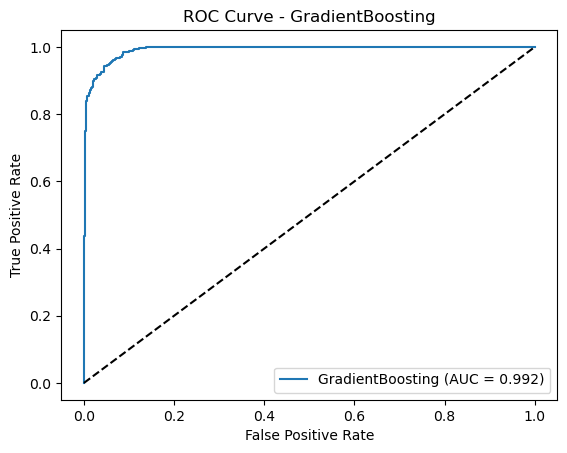

Running KNN
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Best params for KNN:
{'clf__n_neighbors': 15, 'clf__weights': 'distance'}
Best CV ROC AUC: 0.943

Test classification report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       780
           1       0.81      0.79      0.80       350

    accuracy                           0.88      1130
   macro avg       0.86      0.85      0.85      1130
weighted avg       0.87      0.88      0.87      1130

Test ROC AUC: 0.9477802197802198
Confusion matrix:
[[714  66]
 [ 75 275]]


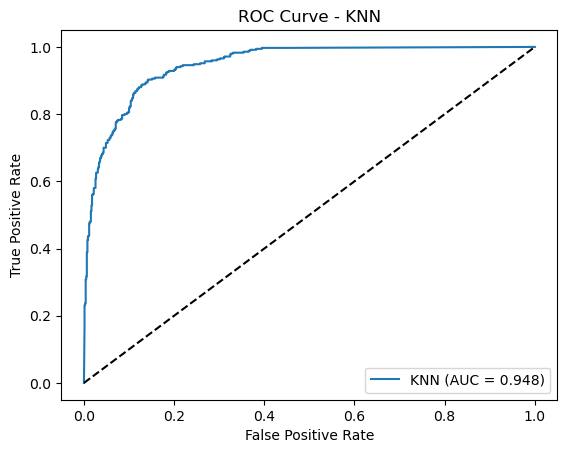

Running SVC
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best params for SVC:
{'clf__C': 10, 'clf__class_weight': 'balanced', 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}
Best CV ROC AUC: 0.966

Test classification report:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       780
           1       0.81      0.95      0.87       350

    accuracy                           0.92      1130
   macro avg       0.89      0.92      0.91      1130
weighted avg       0.92      0.92      0.92      1130

Test ROC AUC: 0.9688626373626373
Confusion matrix:
[[703  77]
 [ 18 332]]


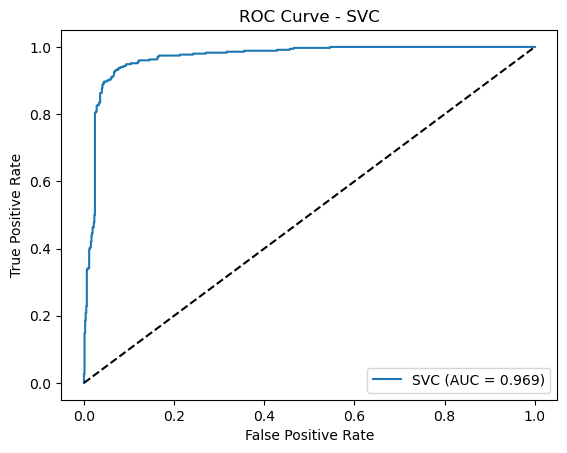

Selected main value model: RandomForest (CV ROC AUC = 0.993, test ROC AUC = 0.991)


In [5]:
best_classifiers = {}  # store best models
cv_results_dict = {}
test_metrics = {}
cv_best_scores = {}

for name, (pipe, param_grid) in classifiers.items():
    print("="*80)
    print(f"Running {name}")
    
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring="roc_auc",   # good for imbalanced classes
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)
    
    print(f"\nBest params for {name}:")
    print(grid.best_params_)
    print(f"Best CV ROC AUC: {grid.best_score_:.3f}")

    cv_best_scores[name] = grid.best_score_
    
    best_model = grid.best_estimator_
    best_classifiers[name] = best_model
    
    # Evaluation on test
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]
    test_auc = roc_auc_score(y_test, y_proba)
    
    print("\nTest classification report:")
    print(classification_report(y_test, y_pred))
    print("Test ROC AUC:", test_auc)
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred))

    test_metrics[name] = {"roc_auc": test_auc}
    
    # Optional: ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"{name} (AUC = {test_auc:.3f})")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend()
    plt.show()

# Choose main model for ranking using CV ROC AUC (keep test set as blind check)
best_model_name = max(cv_best_scores, key=cv_best_scores.get)
value_model = best_classifiers[best_model_name]
print(
    f"Selected main value model: {best_model_name} "
    f"(CV ROC AUC = {cv_best_scores[best_model_name]:.3f}, "
    f"test ROC AUC = {test_metrics[best_model_name]['roc_auc']:.3f})"
)




At the end of this you’ll see realistic metrics (not all 1.0), and you’ll have a best_classifiers dict with tuned models.

Pick one (e.g. RandomForest) as your main value model:

In [6]:
# value_model is chosen from CV scores above


# 4️⃣ REGRESSION models (e.g., predicting QUALITY_SCORE)

Now do the same for regression, predicting something like QUALITY_SCORE (or MD_EARN_WNE_P10 if you prefer).

In [7]:
# Use same feature_cols; drop rows with missing target
reg_df = df.dropna(subset=["QUALITY_SCORE"])
X_reg = reg_df[feature_cols]
y_reg = reg_df["QUALITY_SCORE"]

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reg, y_reg,
    test_size=0.2,
    random_state=42
)

regressors = {}

# 1. Random Forest Regressor
rf_reg_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", RandomForestRegressor(random_state=42))
])

rf_reg_param_grid = {
    "clf__n_estimators": [200, 400],
    "clf__max_depth": [None, 5, 10, 20],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4]
}

regressors["RandomForestRegressor"] = (rf_reg_pipe, rf_reg_param_grid)

# 2. Gradient Boosting Regressor
gb_reg_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", GradientBoostingRegressor(random_state=42))
])

gb_reg_param_grid = {
    "clf__n_estimators": [100, 200],
    "clf__learning_rate": [0.01, 0.1],
    "clf__max_depth": [3, 5]
}

regressors["GradientBoostingRegressor"] = (gb_reg_pipe, gb_reg_param_grid)

# 3. ElasticNet (linear with L1+L2)
en_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", ElasticNet(max_iter=5000))
])

en_param_grid = {
    "clf__alpha": [0.01, 0.1, 1.0, 10.0],
    "clf__l1_ratio": [0.1, 0.5, 0.9]
}

regressors["ElasticNet"] = (en_pipe, en_param_grid)

# 4. Support Vector Regressor
svr_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", SVR())
])

svr_param_grid = {
    "clf__C": [0.1, 1, 10],
    "clf__gamma": ["scale", "auto"],
    "clf__epsilon": [0.01, 0.1, 0.2]
}

regressors["SVR"] = (svr_pipe, svr_param_grid)



# Run it

Running RandomForestRegressor
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Best params for RandomForestRegressor:
{'clf__max_depth': 20, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
Best CV R²: 0.997

Test R²: 0.9937886656447635
Test RMSE: 0.003968351873016054


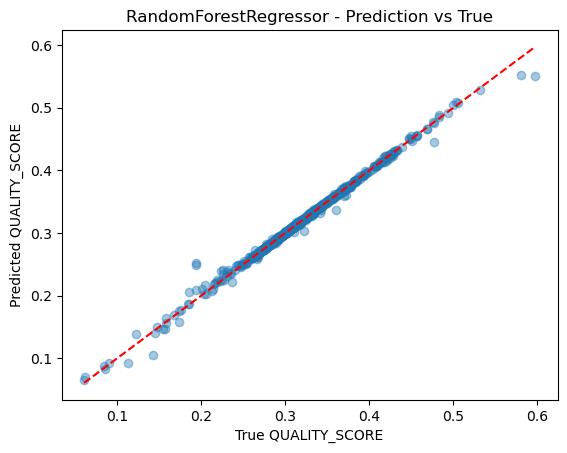

Running GradientBoostingRegressor
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best params for GradientBoostingRegressor:
{'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 200}
Best CV R²: 0.998

Test R²: 0.9947154640965922
Test RMSE: 0.003660337628914635


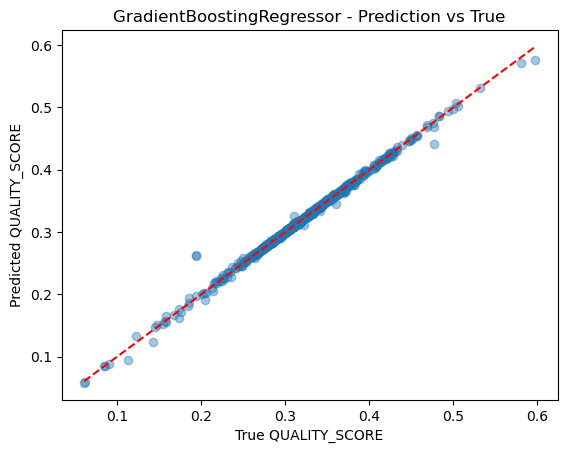

Running ElasticNet
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best params for ElasticNet:
{'clf__alpha': 0.01, 'clf__l1_ratio': 0.1}
Best CV R²: 0.999

Test R²: 0.9988934067011648
Test RMSE: 0.0016749881466746892


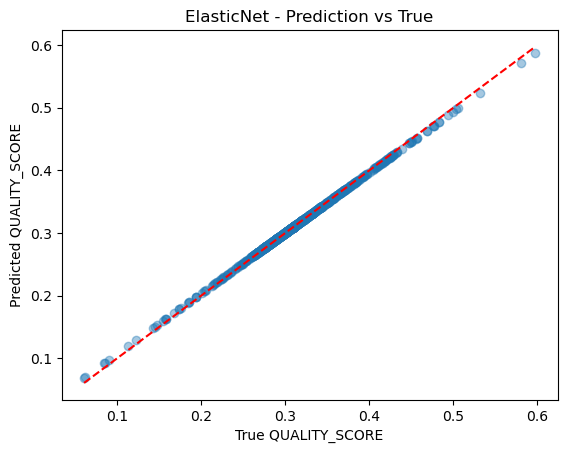

Running SVR
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Best params for SVR:
{'clf__C': 1, 'clf__epsilon': 0.01, 'clf__gamma': 'auto'}
Best CV R²: 0.962

Test R²: 0.975137824157589
Test RMSE: 0.007939392760170144


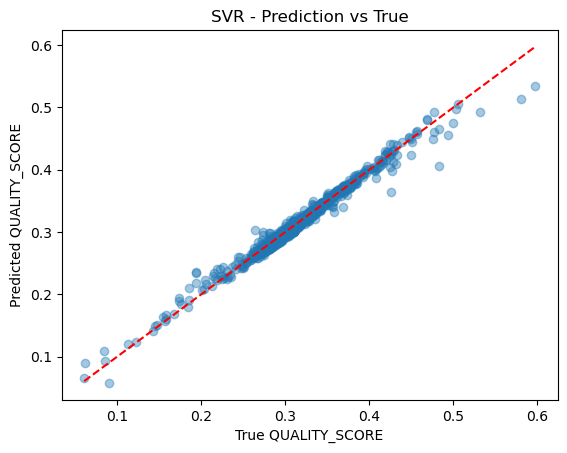

Selected main regression model: ElasticNet (CV R² = 0.999, test R² = 0.999, test RMSE = 0.002)


In [8]:
best_regressors = {}
reg_cv_best_scores = {}
reg_test_metrics = {}

for name, (pipe, param_grid) in regressors.items():
    print("="*80)
    print(f"Running {name}")
    
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring="r2",
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    grid.fit(Xr_train, yr_train)
    
    print(f"\nBest params for {name}:")
    print(grid.best_params_)
    print(f"Best CV R²: {grid.best_score_:.3f}")

    reg_cv_best_scores[name] = grid.best_score_
    
    best_model = grid.best_estimator_
    best_regressors[name] = best_model
    
    # Evaluation on test
    yr_pred = best_model.predict(Xr_test)
    r2 = r2_score(yr_test, yr_pred)
    rmse = mean_squared_error(yr_test, yr_pred, squared=False)
    
    print("\nTest R²:", r2)
    print("Test RMSE:", rmse)
    
    reg_test_metrics[name] = {"r2": r2, "rmse": rmse}
    
    # Optional: plot prediction vs true
    plt.figure()
    plt.scatter(yr_test, yr_pred, alpha=0.4)
    plt.xlabel("True QUALITY_SCORE")
    plt.ylabel("Predicted QUALITY_SCORE")
    plt.title(f"{name} - Prediction vs True")
    plt.plot([yr_test.min(), yr_test.max()], [yr_test.min(), yr_test.max()], "r--")
    plt.show()

# Pick a main regression model using CV R²
best_reg_name = max(reg_cv_best_scores, key=reg_cv_best_scores.get)
quality_model = best_regressors[best_reg_name]
print(
    f"Selected main regression model: {best_reg_name} "
    f"(CV R² = {reg_cv_best_scores[best_reg_name]:.3f}, "
    f"test R² = {reg_test_metrics[best_reg_name]['r2']:.3f}, "
    f"test RMSE = {reg_test_metrics[best_reg_name]['rmse']:.3f})"
)




# Pick a main regression model:

In [9]:
# quality_model is chosen from CV scores above


# 5️⃣ User-weight–based ranking (the “college predictor”)

Now the fun part: user enters weights (0–5) for each criterion, we compute a USER_SCORE and rank colleges.

We’ll combine:

Model’s predicted probability of being value-college

Cost (lower is better)

Engineering intensity (ENG_RATIO)

Earnings (MD_EARN_WNE_P10)

Location preference (same state vs others)

Helper: normalize features 0–1

In [10]:
def minmax_series(s):
    s = s.astype(float)
    return (s - s.min()) / (s.max() - s.min() + 1e-9)


# Build ranking function

In [11]:
def rank_colleges_for_user(
    df_raw,
    feature_cols,
    value_model,
    user_weights,
    preferred_state=None
):
    """
    user_weights: dict with keys like:
        {
          "value_model": 5,
          "cost": 5,
          "engineering": 4,
          "earnings": 3,
          "location": 2
        }
    preferred_state: e.g. "FL" or None
    """
    df_scored = df_raw.copy()
    
    # 1) Model probability of being a high-value college
    X_all = df_scored[feature_cols]
    # Impute in the same way the model expects:
    p_value = value_model.predict_proba(X_all)[:, 1]
    df_scored["p_value_model"] = p_value
    
    # 2) Define component scores (all 0–1, higher = better)
    
    # Cost: lower cost => higher score
    cost_norm = minmax_series(df_scored["COSTT4_A"])
    df_scored["cost_score"] = 1 - cost_norm  # invert
    
    # Engineering intensity: ENG_RATIO already 0–1-ish
    df_scored["eng_score"] = minmax_series(df_scored["ENG_RATIO"])
    
    # Earnings: higher is better
    df_scored["earnings_score"] = minmax_series(df_scored["MD_EARN_WNE_P10"])
    
    # Location score: 1 if preferred_state, else 0 (or 0.5 if no preference)
    if preferred_state is not None:
        df_scored["location_score"] = np.where(
            df_scored["STABBR"] == preferred_state, 1.0, 0.0
        )
    else:
        df_scored["location_score"] = 0.5  # neutral
    
    # 3) Combine with user weights
    w_value = user_weights.get("value_model", 0)
    w_cost = user_weights.get("cost", 0)
    w_eng = user_weights.get("engineering", 0)
    w_earn = user_weights.get("earnings", 0)
    w_loc = user_weights.get("location", 0)
    
    total_w = w_value + w_cost + w_eng + w_earn + w_loc
    if total_w == 0:
        raise ValueError("All user weights are zero!")
    
    df_scored["USER_SCORE"] = (
        w_value * df_scored["p_value_model"] +
        w_cost  * df_scored["cost_score"] +
        w_eng   * df_scored["eng_score"] +
        w_earn  * df_scored["earnings_score"] +
        w_loc   * df_scored["location_score"]
    ) / total_w
    
    # 4) Sort and return a clean table
    cols_to_show = [
        "INSTNM", "CITY", "STABBR",
        "COSTT4_A", "ENG_RATIO", "MD_EARN_WNE_P10",
        "p_value_model", "USER_SCORE"
    ]
    cols_to_show = [c for c in cols_to_show if c in df_scored.columns]
    
    ranked = df_scored.sort_values("USER_SCORE", ascending=False)
    return ranked[cols_to_show]


# Example: user says “cost 5, engineering 4, earnings 3, location (Florida) 2, model weight 5”

In [12]:
user_weights_example = {
    "value_model": 5,
    "cost": 5,
    "engineering": 4,
    "earnings": 3,
    "location": 2
}

preferred_state_example = "FL"

ranked_df = rank_colleges_for_user(
    df_raw=df,
    feature_cols=feature_cols,
    value_model=value_model,
    user_weights=user_weights_example,
    preferred_state=preferred_state_example
)

ranked_df.head(20)


,INSTNM,CITY,STABBR,COSTT4_A,ENG_RATIO,MD_EARN_WNE_P10,p_value_model,USER_SCORE
4964,Electrical and HVAC/R Training Center,Copiague,NY,24517.0,1.000000,40501.5,0.905324,0.685546
1384,Northwestern Technological Institute,Southfield,MI,24517.0,1.000000,41237.0,0.893455,0.683284
4788,Tulsa Welding School-Jacksonville,Jacksonville,FL,24517.0,0.347200,41067.0,0.970418,0.671170
635,Seminole State College of Florida,Sanford,FL,9152.0,0.081092,41733.0,0.980070,0.666874
2081,United States Merchant Marine Academy,Kings Point,NY,9547.0,0.520500,90610.0,0.806873,0.664550
564,Florida State College at Jacksonville,Jacksonville,FL,8994.0,0.031897,42244.0,0.978384,0.657170
586,Hillsborough Community College,Tampa,FL,10168.0,0.014101,40782.0,0.979421,0.648285
631,St Petersburg College,St. Petersburg,FL,10634.0,0.011003,42557.0,0.970666,0.645940
638,Saint Johns River State College,Palatka,FL,12215.0,0.035004,41728.0,0.955374,0.641017
623,Polk State College,Winter Haven,FL,12709.0,0.022900,40624.0,0.966743,0.638611


This gives you a ranked table of colleges, customized to that user’s preference.
They can change the weights (0–5) and state, rerun, and get a different ranking.

How this answers what you asked

✅ “I have the preprocessed data and I wanna make good ML models to get a college predictor”
→ Multi-model classification + regression with GridSearchCV + evaluation.

✅ “It should also have weights that the users will enter”
→ rank_colleges_for_user uses user-defined weights /5 to build a USER_SCORE and rank schools.

✅ “Code a lot of ML models… good amount of important hyperparameters… good reports… GSCV”
→ Logistic + RF + GB + KNN on classification; RF + GB + ElasticNet on regression, all with GridSearchCV, hyperparameter grids, and printed reports + plots.

If you want, next step I can help you:

interpret the first set of real (not 1.0) metrics you get,

or tweak the scoring formula (like adding a “research intensity” or “public vs private” preference slider).

# Next

This adds:

research intensity weight (using QUALITY_SCORE or MD_EARN_WNE_P10 as proxy)

public vs private preference (two sliders: prefer_public and prefer_private)

keeps all your old weights (value_model, cost, engineering, earnings, location)

It defines a new function rank_colleges_for_user_v2 so your old one still works.

🔧 New block: extended scoring with research + sector preferences

In [13]:
# -------------------------------------------------------------------
# Extended ranking function with research intensity + public/private preference
# Run this AFTER you have: df, feature_cols, value_model, and minmax_series defined
# -------------------------------------------------------------------

def rank_colleges_for_user_v2(
    df_raw,
    feature_cols,
    value_model,
    user_weights,
    preferred_state=None
):
    """
    user_weights example:
        {
          "value_model": 5,      # how much to trust the ML "value" model
          "cost": 5,             # lower cost preference
          "engineering": 4,      # engineering intensity
          "earnings": 3,         # graduate earnings
          "location": 2,         # same-state preference
          "research": 4,         # research / quality preference
          "prefer_public": 3,    # prefer public schools
          "prefer_private": 0    # prefer private (set >0 if you want that instead)
        }
    preferred_state: e.g. "FL" or None
    """
    df_scored = df_raw.copy()

    # ---------------------------
    # 1) Model probability (same as before)
    # ---------------------------
    X_all = df_scored[feature_cols]
    p_value = value_model.predict_proba(X_all)[:, 1]
    df_scored["p_value_model"] = p_value

    # ---------------------------
    # 2) Base component scores (0–1, higher = better)
    # ---------------------------

    # Cost: lower cost => higher score
    cost_norm = minmax_series(df_scored["COSTT4_A"])
    df_scored["cost_score"] = 1 - cost_norm  # invert

    # Engineering intensity
    df_scored["eng_score"] = minmax_series(df_scored["ENG_RATIO"])

    # Earnings
    if "MD_EARN_WNE_P10" in df_scored.columns:
        df_scored["earnings_score"] = minmax_series(df_scored["MD_EARN_WNE_P10"])
    else:
        df_scored["earnings_score"] = 0.5  # neutral if missing

    # Location: same state vs others
    if preferred_state is not None and "STABBR" in df_scored.columns:
        df_scored["location_score"] = np.where(
            df_scored["STABBR"] == preferred_state, 1.0, 0.0
        )
    else:
        df_scored["location_score"] = 0.5  # neutral

    # ---------------------------
    # 3) Research / quality score
    # ---------------------------
    if "QUALITY_SCORE" in df_scored.columns:
        df_scored["research_score"] = minmax_series(df_scored["QUALITY_SCORE"])
    elif "MD_EARN_WNE_P10" in df_scored.columns:
        # fallback: use earnings as proxy if QUALITY_SCORE missing
        df_scored["research_score"] = minmax_series(df_scored["MD_EARN_WNE_P10"])
    else:
        df_scored["research_score"] = 0.5

    # ---------------------------
    # 4) Public vs Private sector preference
    # ---------------------------
    # sector_indicator: 1 = public, 0 = private, 0.5 = for-profit/other
    if all(c in df_scored.columns for c in ["IS_PUBLIC", "IS_PRIVATE", "IS_FORPROFIT"]):
        sector_indicator = np.where(
            df_scored["IS_PUBLIC"] == 1, 1.0,
            np.where(df_scored["IS_PRIVATE"] == 1, 0.0, 0.5)
        )
    else:
        # If sector flags missing, treat all as neutral
        sector_indicator = np.full(len(df_scored), 0.5)

    df_scored["sector_indicator"] = sector_indicator

    # Human-readable sector label (just for display)
    if all(c in df_scored.columns for c in ["IS_PUBLIC", "IS_PRIVATE", "IS_FORPROFIT"]):
        df_scored["SECTOR"] = np.select(
            [
                df_scored["IS_PUBLIC"] == 1,
                df_scored["IS_PRIVATE"] == 1,
                df_scored["IS_FORPROFIT"] == 1
            ],
            ["Public", "Private", "For-profit"],
            default="Other"
        )
    else:
        df_scored["SECTOR"] = "Unknown"

    # ---------------------------
    # 5) Combine with user weights
    # ---------------------------
    w_value   = user_weights.get("value_model", 0)
    w_cost    = user_weights.get("cost", 0)
    w_eng     = user_weights.get("engineering", 0)
    w_earn    = user_weights.get("earnings", 0)
    w_loc     = user_weights.get("location", 0)
    w_research = user_weights.get("research", 0)

    # Sector preferences: user should set ONE of these > 0 ideally
    w_public  = user_weights.get("prefer_public", 0)
    w_private = user_weights.get("prefer_private", 0)

    # Total weight for sector preference
    w_sector = w_public + w_private

    # Each preference sees sector differently:
    # - For public preference, score = sector_indicator (1 for public)
    # - For private preference, score = 1 - sector_indicator (1 for private)
    sector_score_component = (
        w_public  * df_scored["sector_indicator"] +
        w_private * (1 - df_scored["sector_indicator"])
    )

    # Total weight in denominator
    total_w = (
        w_value + w_cost + w_eng + w_earn + w_loc +
        w_research + w_sector
    )

    if total_w == 0:
        raise ValueError("All user weights are zero! Please set at least one > 0.")

    # Weighted average score
    df_scored["USER_SCORE"] = (
        w_value   * df_scored["p_value_model"] +
        w_cost    * df_scored["cost_score"] +
        w_eng     * df_scored["eng_score"] +
        w_earn    * df_scored["earnings_score"] +
        w_loc     * df_scored["location_score"] +
        w_research * df_scored["research_score"] +
        sector_score_component
    ) / total_w

    # ---------------------------
    # 6) Sort and return nice table
    # ---------------------------
    cols_to_show = [
        "INSTNM", "CITY", "STABBR", "SECTOR",
        "COSTT4_A", "ENG_RATIO", "MD_EARN_WNE_P10", "QUALITY_SCORE",
        "p_value_model", "USER_SCORE"
    ]
    cols_to_show = [c for c in cols_to_show if c in df_scored.columns]

    ranked = df_scored.sort_values("USER_SCORE", ascending=False)
    return ranked[cols_to_show]


# -------------------------------------------------------------------
# Example usage of the new function
# -------------------------------------------------------------------

user_weights_v2 = {
    "value_model": 5,
    "cost": 5,
    "engineering": 4,
    "earnings": 3,
    "location": 2,
    "research": 4,       # how much research/quality matters
    "prefer_public": 3,  # prefer public schools
    "prefer_private": 0  # set >0 instead if you want to favor private
}

preferred_state_v2 = "FL"  # or None for no location preference

ranked_v2 = rank_colleges_for_user_v2(
    df_raw=df,
    feature_cols=feature_cols,
    value_model=value_model,
    user_weights=user_weights_v2,
    preferred_state=preferred_state_v2
)

# Show top 20
ranked_v2.head(20)


,INSTNM,CITY,STABBR,SECTOR,COSTT4_A,ENG_RATIO,MD_EARN_WNE_P10,QUALITY_SCORE,p_value_model,USER_SCORE
2081,United States Merchant Marine Academy,Kings Point,NY,Public,9547.0,0.520500,90610.0,0.459446,0.806873,0.716716
5015,University of Florida-Online,Gainesville,FL,Public,17036.0,0.000000,71588.0,0.430294,0.857184,0.681633
635,Seminole State College of Florida,Sanford,FL,Public,9152.0,0.081092,41733.0,0.312744,0.980070,0.677757
572,Florida International University,Miami,FL,Public,20556.0,0.073993,60249.0,0.400898,0.899925,0.675279
564,Florida State College at Jacksonville,Jacksonville,FL,Public,8994.0,0.031897,42244.0,0.313813,0.978384,0.670961
563,Florida Atlantic University,Boca Raton,FL,Public,21054.0,0.043696,56746.0,0.371218,0.960781,0.669950
640,University of South Florida,Tampa,FL,Public,22301.0,0.056706,57743.0,0.395144,0.919985,0.668720
614,University of North Florida,Jacksonville,FL,Public,20229.0,0.060906,56343.0,0.361435,0.926479,0.664844
586,Hillsborough Community College,Tampa,FL,Public,10168.0,0.014101,40782.0,0.310754,0.979421,0.663621
578,Florida State University,Tallahassee,FL,Public,23683.0,0.038504,61675.0,0.415971,0.876711,0.663554


We get:

A more flexible scoring formula

A research/quality slider

A public vs private preference baked into the ranking